# *Nov 24 monthly Demo - Runge*

This notebook contains all of the code used to produce the results and figures included in the paper

### Load dependencies

In [27]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [28]:
scenario_3_total_popp =100000 # US Census Bureau
initial_vacc = 0
initial_hosp = 0
initial_recovered = 0
initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 99900
initial_ccases = 0
initial_chosp = 0

# Model derivation and initialization

### Define units

In [29]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [30]:
c = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'V': Concept(name="V", units=person_units()),  # Vaccinated
    'I': Concept(name='I', units=person_units()),  # Infectious
    'R': Concept(name='R', units=person_units()),  # Recovered
    'H': Concept(name="H", units=person_units()),  # Hospitalized
    'D': Concept(name="D", units=person_units()),  # Deceased
    'C_c': Concept(name="C_c", units=person_units()),  # Cumulative Cases
    'C_h': Concept(name="C_h", units=person_units())  # Cumulative Hospitalizations
}

for concept in c:
    c[concept].name = concept


### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [31]:

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.6), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp), units=person_units()),  
    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Vaccination rate
    'sigma': Parameter(name='sigma', value=sympy.Float(0.10), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'epsilon': Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units()),  # Rate exposed and vaccinated individuals become infected
    'delta': Parameter(name='delta', value=sympy.Float(0.05), units=per_day_units()),  # Rate infected individuals recover
    'gamma': Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units()),  # Rate infected individuals become hospitalized
    'alpha': Parameter(name='alpha', value=sympy.Float(0.01), units=per_day_units()),  # Death rate for infected individuals who are not hospitalized
    'rho': Parameter(name='rho', value=sympy.Float(0.10), units=per_day_units()),  # Rate hospitalized individuals recover
    'mu': Parameter(name='mu', value=sympy.Float(0.02), units=per_day_units()),  # Death rate for hospitalized individuals
}

parameters_q1 = parameters.copy()
parameters_q1['epsilon'] = Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.05,
                                                            'maximum': 1.5*0.05}))
parameters_q1['gamma'] = Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.02,
                                                            'maximum': 1.5*0.02}))


### Define `SymPy` variables

In [32]:
S, E, I, R, H, V, D,  C_c, C_h, beta, N, nu, sigma, epsilon, delta, gamma, alpha, rho, mu = sympy.symbols('S E I R H V D C_c C_h beta N nu sigma epsilon delta gamma alpha rho mu')

### Set initial conditions

In [33]:

initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_infected),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    'C_c': Initial(concept=c["C_c"], expression=initial_ccases),
    'C_h': Initial(concept=c["C_h"], expression=initial_chosp),
}

### Define templates

In [34]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


##### V - E # even though the diagram doesn't have V -> E, the equation does include V*I/N to calculate Exposed
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=epsilon*V*I / N
)


# S -> V
rv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=nu*S
)

#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=delta*I # not r_IR*(1 - r_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=gamma*I # not r_IR*r_IH*I as in previous model
)

#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=alpha*I
)

#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=rho*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=mu*H
)


### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)

# Cumulative Hospitalizations
chosp = ControlledProduction(
    controller=c['I'],
    outcome=c['C_h'],
    rate_law=gamma*I # instead of r_IR*r_IH*I as orignal due to being a different model (i guess)
)

# List of all transitions
transitions = [se, ve, rv, ei, ir, ih, id, hr, hd, ccases, chosp]




### Define observables

In [35]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c),
    'c_hosp': Observable(name='c_hosp', expression=C_h),
}

### Define template model and save as petrinet AMR

In [36]:
model1 = "scenerio_3_mo.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model1, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

### 4.1 Sensitivity Analysis

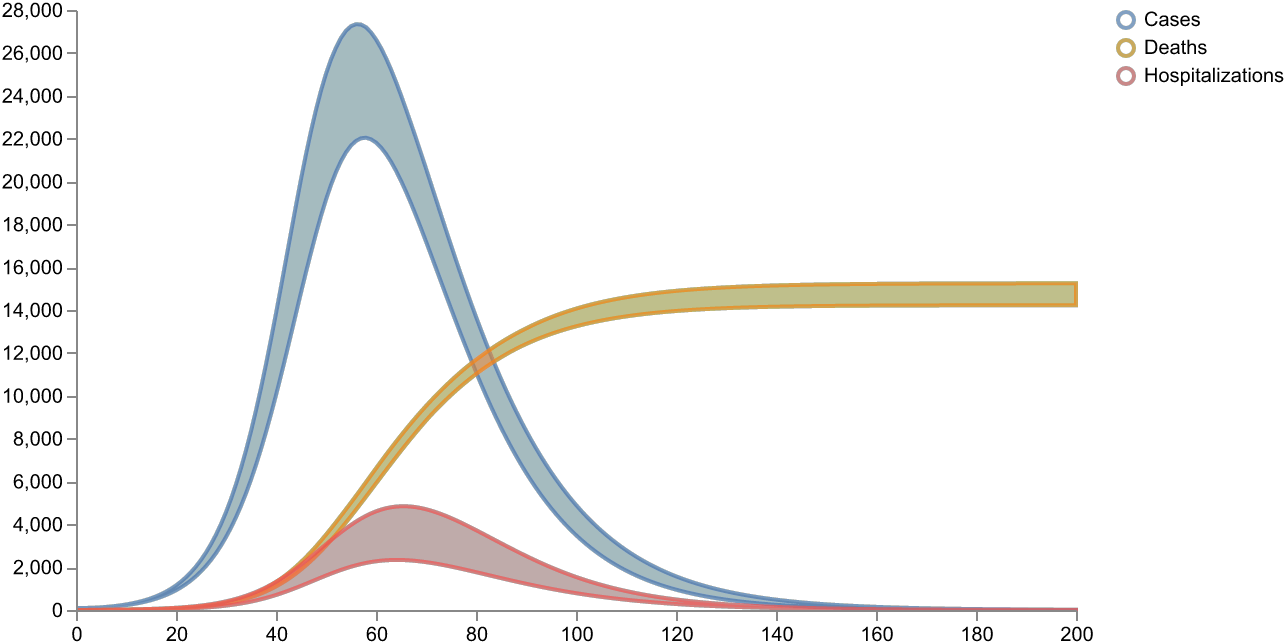

In [37]:
result_sensitivity = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result_sensitivity["data"], 
    keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [38]:
result_sensitivity['data']

,timepoint_id,sample_id,timepoint_unknown,persistent_epsilon_param,persistent_gamma_param,persistent_N_param,persistent_beta_param,persistent_nu_param,persistent_sigma_param,persistent_delta_param,...,R_state,H_state,D_state,C_c_state,C_h_state,cases_observable_state,hospitalized_observable_state,deceased_observable_state,c_cases_observable_state,c_hosp_observable_state
0,0,0,0.0,0.029175,0.028457,100000.0,0.6,0.005,0.1,0.05,...,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,1.0,0.029175,0.028457,100000.0,0.6,0.005,0.1,0.05,...,4.965364,2.589938,0.993072,2.824103,2.750060,94.275726,2.589938,0.993072,2.824103,2.750060
2,2,0,2.0,0.029175,0.028457,100000.0,0.6,0.005,0.1,0.05,...,10.022406,4.809520,2.004482,10.752165,5.416368,93.915733,4.809520,2.004482,10.752165,5.416368
3,3,0,3.0,0.029175,0.028457,100000.0,0.6,0.005,0.1,0.05,...,15.385367,6.830314,3.077074,23.247173,8.136823,97.954453,6.830314,3.077074,23.247173,8.136823
4,4,0,4.0,0.029175,0.028457,100000.0,0.6,0.005,0.1,0.05,...,21.244900,8.783879,4.248981,40.071899,11.027350,105.794136,8.783879,4.248981,40.071899,11.027350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,196,99,196.0,0.071438,0.022102,100000.0,0.6,0.005,0.1,0.05,...,76115.312500,4.033989,15223.059570,91252.671875,24589.642578,10.249891,4.033989,15223.059570,91252.671875,24589.642578
20096,197,99,197.0,0.071438,0.022102,100000.0,0.6,0.005,0.1,0.05,...,76116.203125,3.784482,15223.231445,91252.890625,24589.855469,9.613672,3.784482,15223.231445,91252.890625,24589.855469
20097,198,99,198.0,0.071438,0.022102,100000.0,0.6,0.005,0.1,0.05,...,76117.046875,3.550355,15223.404297,91253.015625,24590.070312,9.016912,3.550355,15223.404297,91253.015625,24590.070312
20098,199,99,199.0,0.071438,0.022102,100000.0,0.6,0.005,0.1,0.05,...,76117.835938,3.330675,15223.560547,91253.218750,24590.265625,8.457158,3.330675,15223.560547,91253.218750,24590.265625


In [39]:
# import seaborn as sns

# result1["data"][result1["data"]["timepoint_id"] == 10]
# result1["data"].columns
# param_columns = [col for col in result1["data"].columns if col.endswith('_param')]
# min_max_values = {col: (result1["data"][col].min(), result1["data"][col].max()) for col in param_columns}
# print(min_max_values)
# plt.figure(figsize=(12, 6))
# # Create a heatmap for persistent_beta_param and persistent_mu_param
# heatmap_data = result1["data"][['persistent_beta_param', 'persistent_mu_param', 'cases_observable_state']]
# heatmap_data

# heatmap_data_avg = heatmap_data.groupby(['persistent_beta_param', 'persistent_mu_param']).mean().reset_index()
# heatmap_data_pivot = heatmap_data_avg.pivot("persistent_beta_param", "persistent_mu_param", "cases_observable_state")
# print(heatmap_data_pivot)
# sns.heatmap(heatmap_data_pivot, cmap="YlGnBu", annot=False)
# plt.title("Heatmap of Cases Observable State")
# plt.show()


[19124.23242188 20894.73632812 22551.45117188 21323.16992188
 25158.02734375 20339.68164062 25184.375      22450.70703125
 18636.15234375 23236.77148438 22017.81640625 20160.55664062
 20100.65039062 22316.02148438 21050.62304688 24481.77734375
 20701.88671875 22760.98632812 22629.75390625 22096.17773438
 26114.31640625 21751.56445312 22566.05664062 21664.17773438
 23122.66210938 20627.72070312 20049.46875    23208.62304688
 19357.59179688 20084.921875   22021.79296875 20631.84375
 20181.68164062 20996.76757812 22021.375      20375.109375
 20232.59765625 19767.37695312 20612.625      22306.86523438
 21155.21484375 24952.625      25326.36132812 23359.71289062
 21622.00390625 20950.75390625 24625.43359375 23945.25195312
 23939.63671875 18824.90820312 22547.90820312 21452.00976562
 22608.01757812 25260.98828125 19157.6640625  24905.65039062
 24248.9296875  21504.90039062 22807.45507812 21130.60742188
 20450.42382812 19676.85742188 21703.15039062 21291.09179688
 20442.77148438 20267.65625  

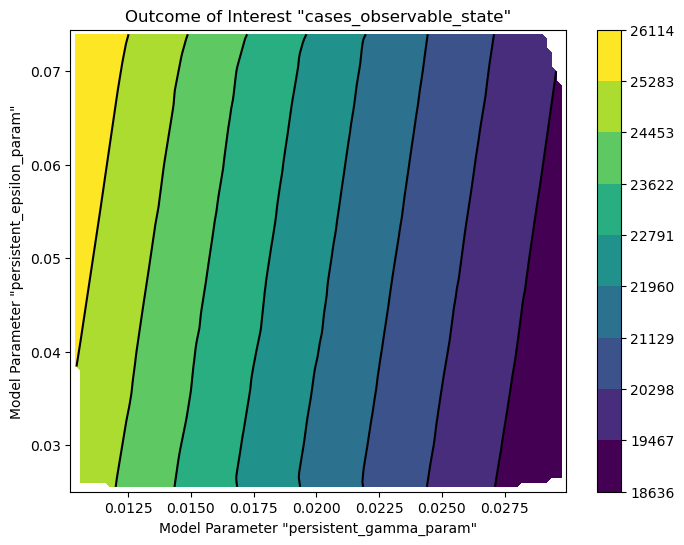

In [40]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

d1 = result_sensitivity["data"]
\
def get_contour_plot(d1, x, column_x, column_y, outcome):

    n = d1["sample_id"].max()
    b = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_x].iloc[0] for i in range(n)])
    rHR = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_y].iloc[0] for i in range(n)])
    outcomes = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][outcome].iloc[0] for i in range(n)])
    print(outcomes)

    xy = np.c_[b, rHR]
    lut2 = LinearNDInterpolator(xy, outcomes)

    # Interpolate to a uniform grid
    m = 100
    x = np.linspace(b.min(), b.max(), m)
    y = np.linspace(rHR.min(), rHR.max(), m)
    xx, yy = np.meshgrid(x, y)

    zz = lut2(xx, yy)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    h1 = ax.contourf(xx, yy, zz, np.linspace(outcomes.min(), outcomes.max(), 10), cmap=plt.cm.viridis.resampled(10 - 1))
    h2 = ax.contour(xx, yy, zz, h1.levels, colors='k')
    __ = fig.colorbar(h1, ax=ax)

    __ = plt.setp(ax, xlabel=f'Model Parameter "{column_x}"', ylabel=f'Model Parameter "{column_y}"', title=f'Outcome of Interest "{outcome}"')

get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "cases_observable_state")


### 4.2 Decision Maker


In [41]:
# 𝛼 (alpha) r_ID  = 0.01 / 𝑑𝑎𝑦 is the death rate for infected individuals who are not hospitalized
# 𝛽 (beta) r_SE= 0.60 new infections per infected person/day is the transmission rate
# 𝛿 (delta) r_IR= 0.05 / 𝑑𝑎𝑦 is the rate infected individuals recover
# 𝜖 (epsilon) r_VE (I think the diagram in pdf is wrong V goes to E, not I based on the equations)= 0.05 / 𝑑𝑎𝑦 is the rate exposed and vaccinated individuals become infected
# 𝛾 (gamma) r_IH = 0.02 / 𝑑𝑎𝑦 is the rate infected individuals become hospitalized
# 𝜇 (mu) r_HD = 0.02 / 𝑑𝑎𝑦 is the death rate for hospitalized individuals
# 𝜈 (nu) r_SV = 0.005 / 𝑑𝑎𝑦 is the vaccination rate
# 𝜌 (rho) r_HR = 0.10 / 𝑑𝑎𝑦 is the rate hospitalized individuals recover
# 𝜎 (sigma) r_EI = 0.10 / 𝑑𝑎𝑦 is the rate exposed and unvaccinated individuals become infected

In [42]:
model_intervention = "scenerio_3_mo_intervention.json"
start_time = 0.0
end_time = 200.0

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


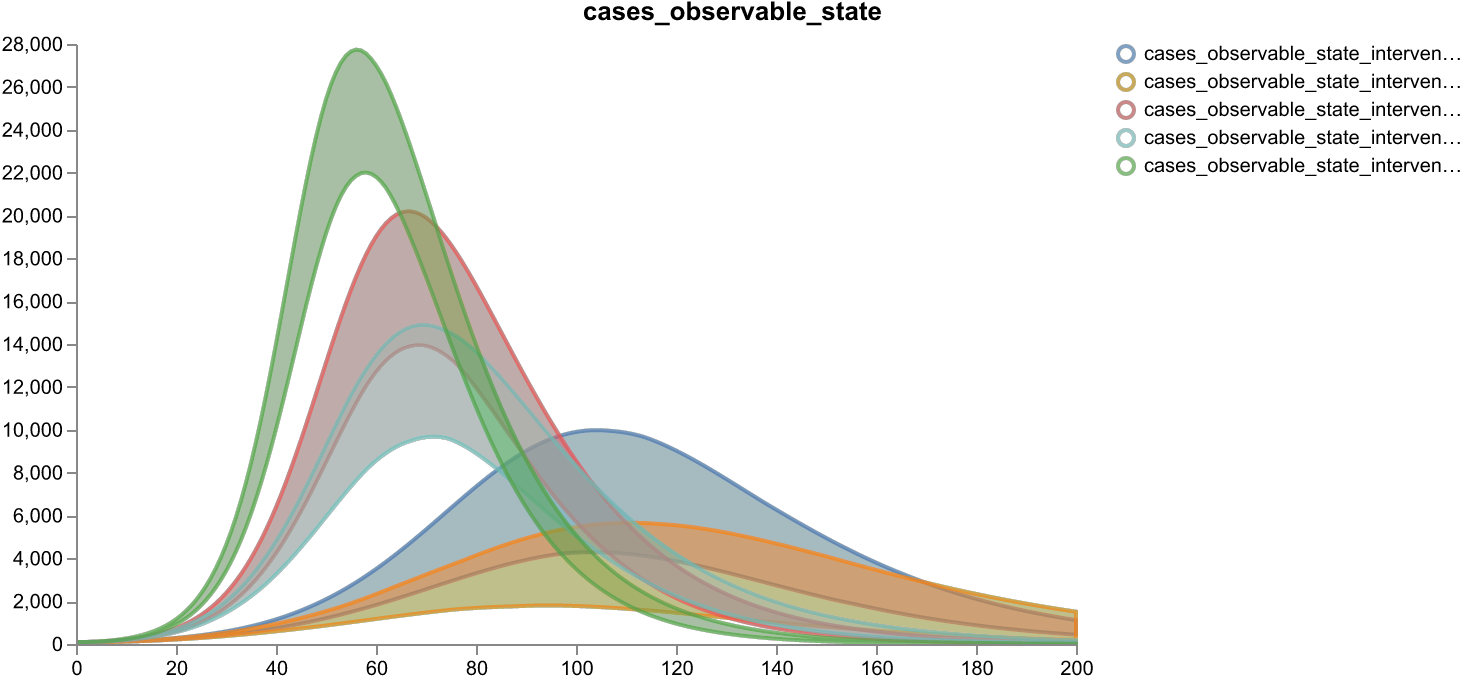

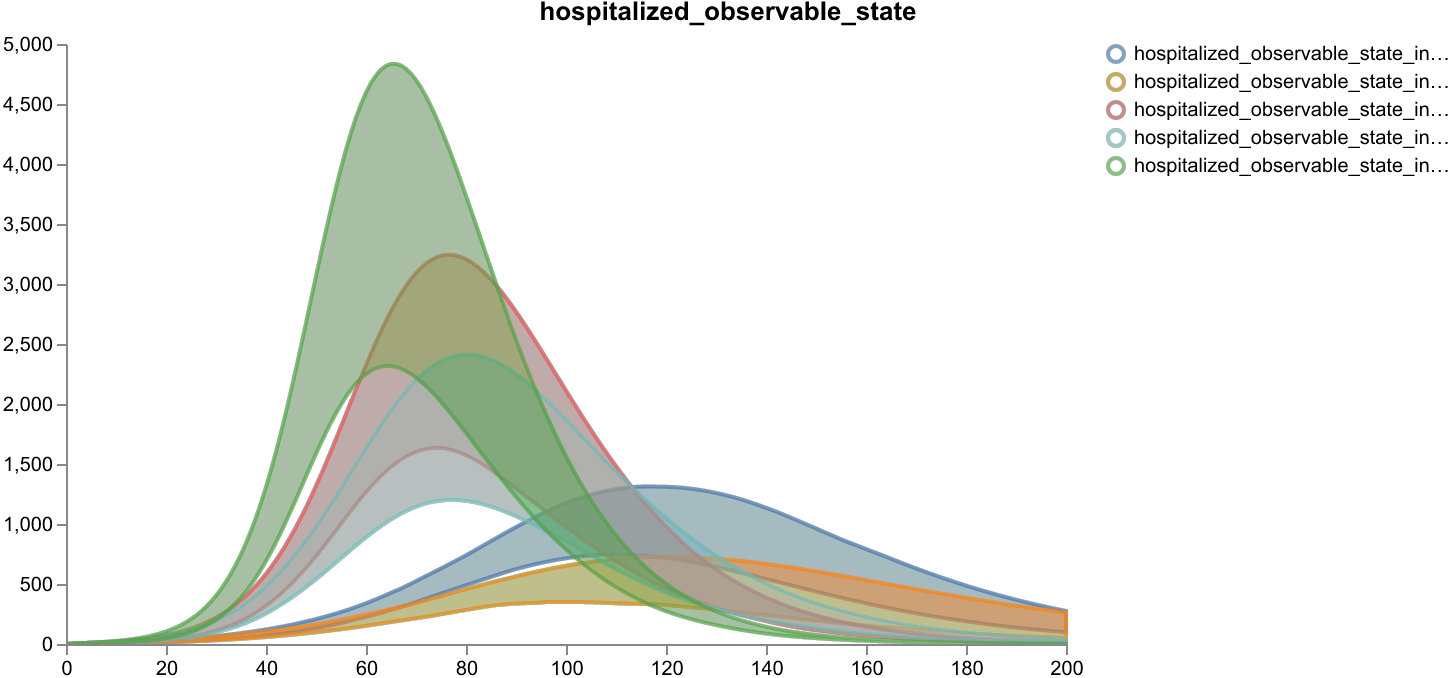

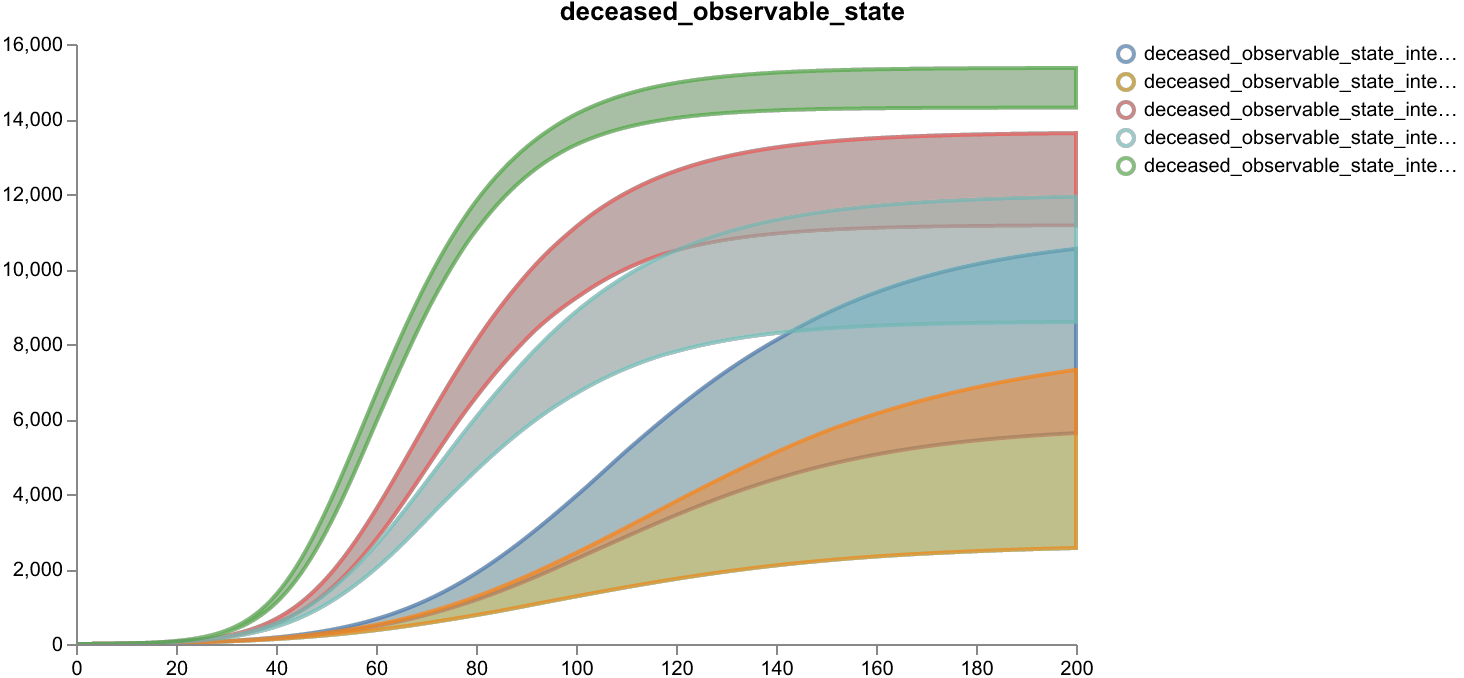

In [55]:
interventions = {
    "none": {},
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
nice_labels = {
    "cases_observable_state": "Cases",
    "hospitalized_observable_state": "Hospitalizations", 
    "deceased_observable_state": "Deaths"
}
results_dict = {}

all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]

    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict[f"intervention_{key}"] = intervention_results



# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=nice_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))


In [56]:
import pandas as pd


results_dict
# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Hospitalizations,Deaths
intervention_none,7.74,2.59,14789.14
intervention_beta_085_nu_001,45.63,13.32,12299.03
intervention_beta_050_nu_001,892.61,179.37,8444.43
intervention_beta_085_nu_015,90.48,24.78,9791.28
intervention_beta_050_nu_015,775.45,144.57,4784.10


### 4.3 Decision Maker + Uncertainity at 50 days



In [ ]:
model_intervention_distribution = "scenerio_3_mo_intervention_uncertainity.json"
start_time = 0.0
end_time = 50.0

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention_distribution, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


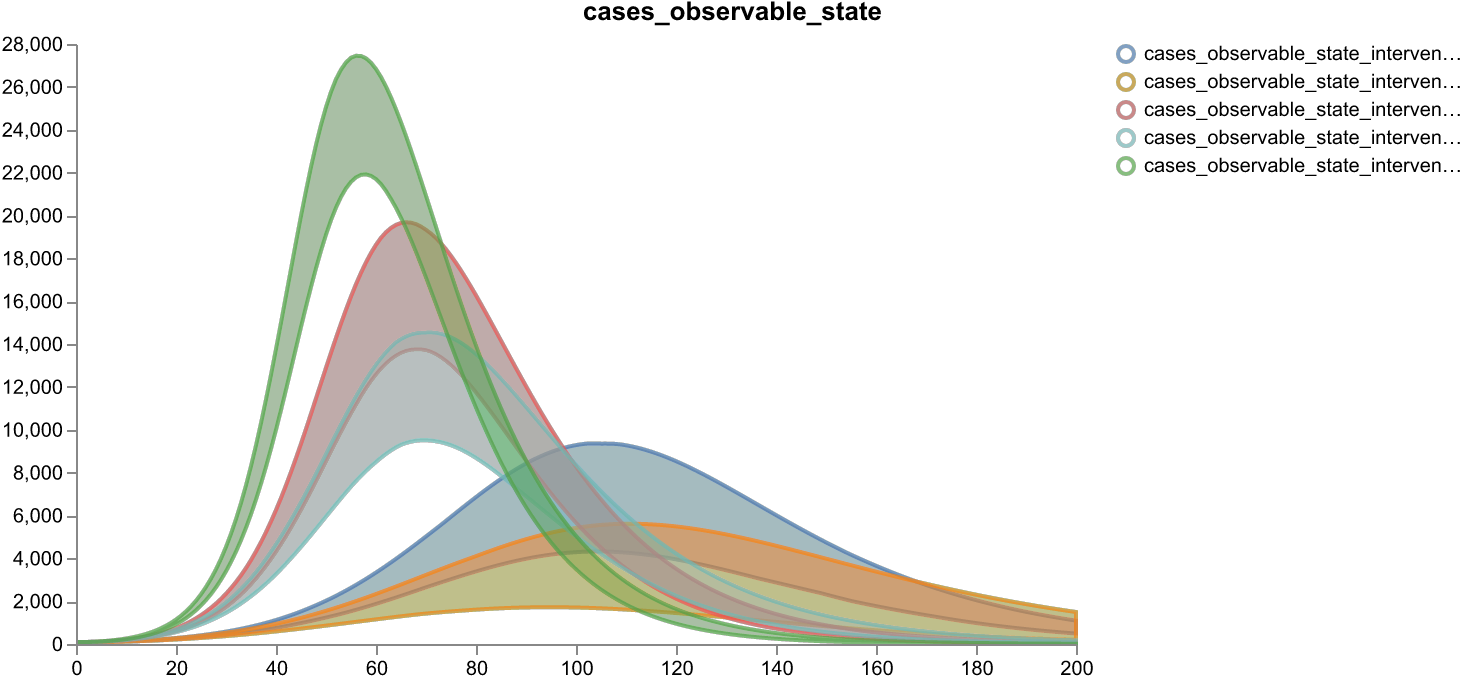

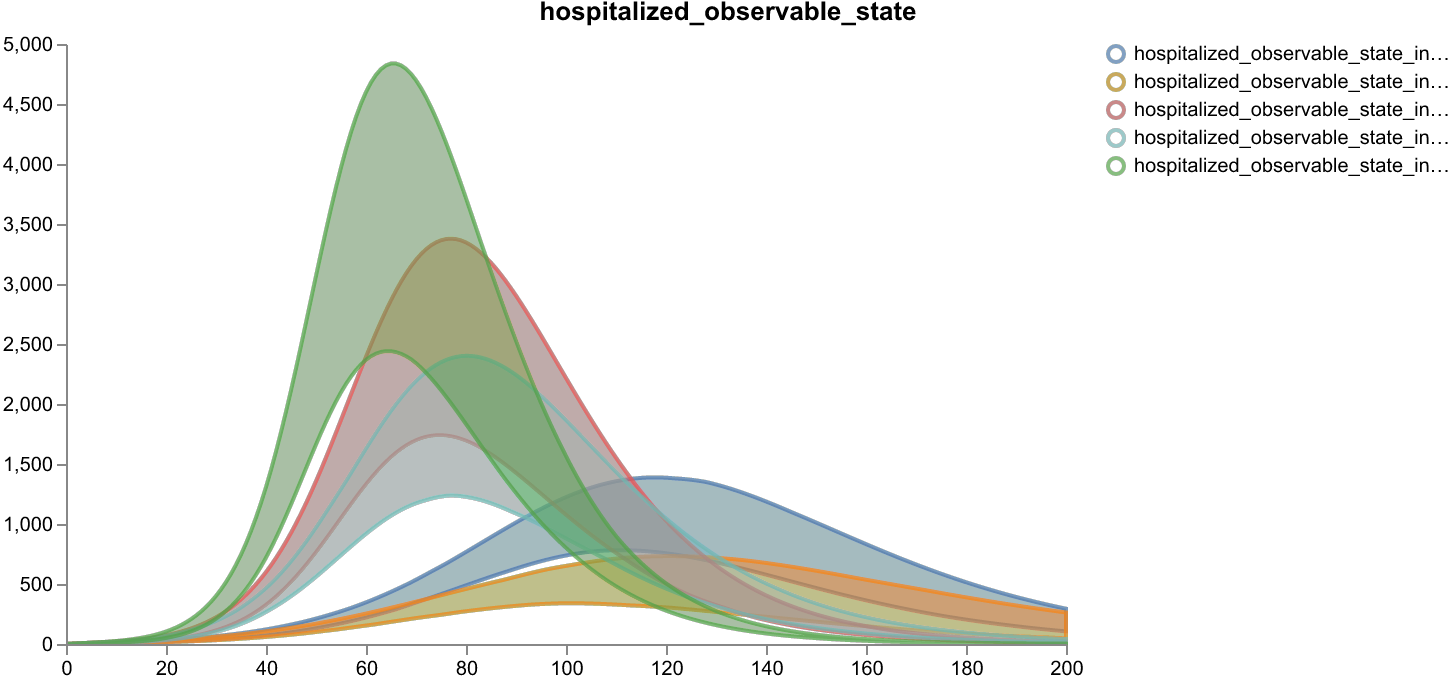

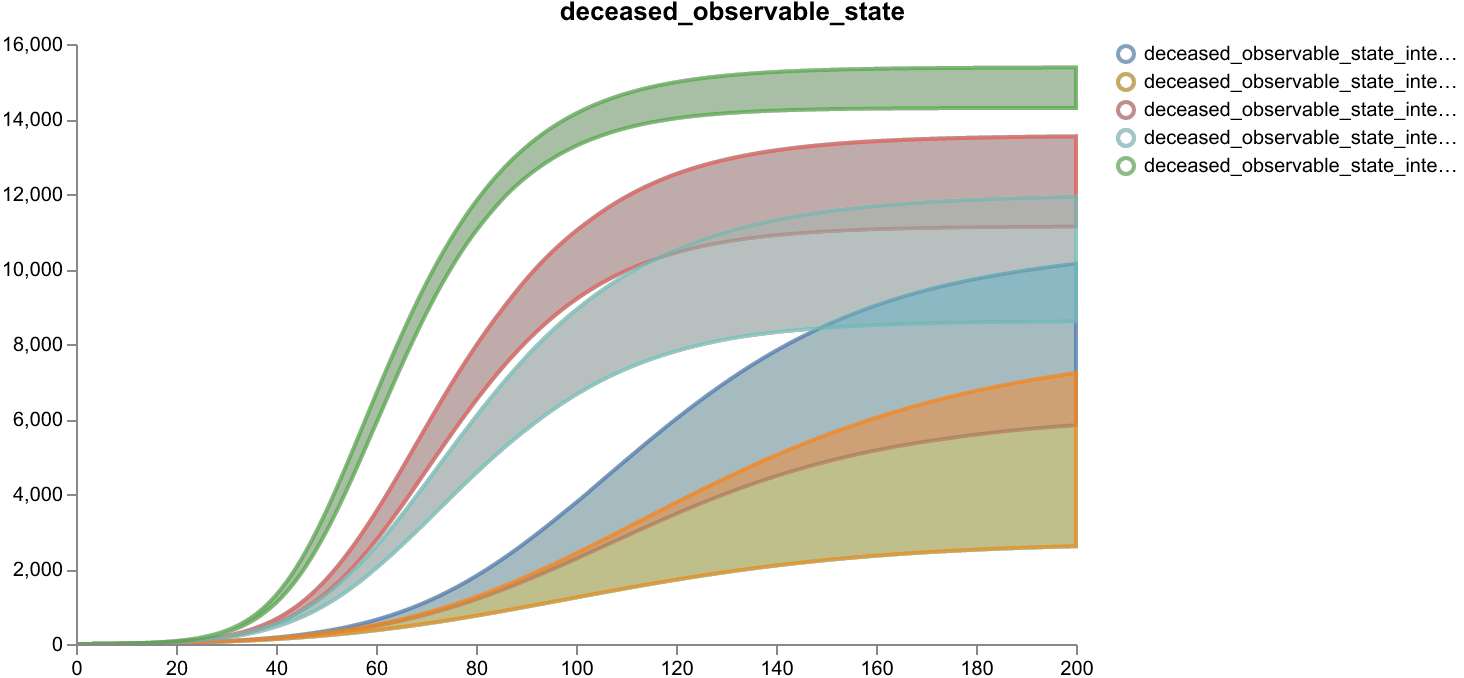

In [59]:

interventions = {
    "none": {},
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
nice_labels = {
    "cases_observable_state": "Cases",
    "hospitalized_observable_state": "Hospitalizations", 
    "deceased_observable_state": "Deaths"
}
results_dict_dist = {}

all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]

    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_dist[f"intervention_{key}"] = intervention_results



# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=nice_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))

In [60]:
import pandas as pd


results_dict
# Calculate the median of the values of the array within the dictionary
median_results = {key: {k: np.round(np.median(v), 2) for k, v in value.items()} for key, value in results_dict.items()}

# Turn the results into a table
median_df = pd.DataFrame(median_results).T
median_df
#

,Cases,Hospitalizations,Deaths
intervention_none,7.29,2.68,14824.76
intervention_beta_085_nu_001,47.90,13.42,12417.99
intervention_beta_050_nu_001,825.70,167.82,8158.77
intervention_beta_085_nu_015,96.45,25.08,9946.37
intervention_beta_050_nu_015,730.26,137.70,4677.96


### 4.4 Horizon Scanning Maker


In [47]:
scenario_3_total_popp_seid =800000 # US Census Bureau

initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 79900
initial_ccases = 0


In [48]:
c_seid = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'I': Concept(name='I', units=person_units()),  # Infectious
    'D': Concept(name='D', units=person_units()),  # Recovered
    'C_c': Concept(name="C_c", units=person_units())  # Cumulative Cases
}

for concept in c_seid:
    c_seid[concept].name = concept


In [62]:
parameters_seid = {
    'beta': Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .2,
                                                            'maximum': .8})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp_seid), units=person_units()),  
    'sigma': Parameter(name='sigma', value=sympy.Float(0.15), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'mu': Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .05,
                                                            'maximum': .1})),  # Death rate for hospitalized individuals
}
parameters_seid_mu_max = parameters_seid.copy()
parameters_seid_mu_max['mu'] = Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .075,
                                                            'maximum': .1}))

parameters_seid_beta_max = parameters_seid.copy()
parameters_seid_beta_max['beta'] = Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .6,
                                                            'maximum': .8}))

In [50]:

initials_seid = {
    "S": Initial(concept=c_seid["S"], expression=initial_susceptible),
    "E": Initial(concept=c_seid["E"], expression=initial_exposed),
    "I": Initial(concept=c_seid["I"], expression=initial_infected),
    "D": Initial(concept=c_seid["D"], expression=initial_deaths),
    "C_c": Initial(concept=c_seid["C_c"], expression=initial_ccases),
}


In [51]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)




#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=mu*I
)



### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)


# List of all transitions
transitions_seid = [se, ei, id, ccases]



In [52]:
observables_seid = {
    'cases': Observable(name='cases', expression=I),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c)
}

In [65]:
model_seid = "scenerio_3_mo_seid.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_beta_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_beta_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

seir_model_mu_max = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid_mu_max,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)
# Save as JSON
with open(model_seid, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

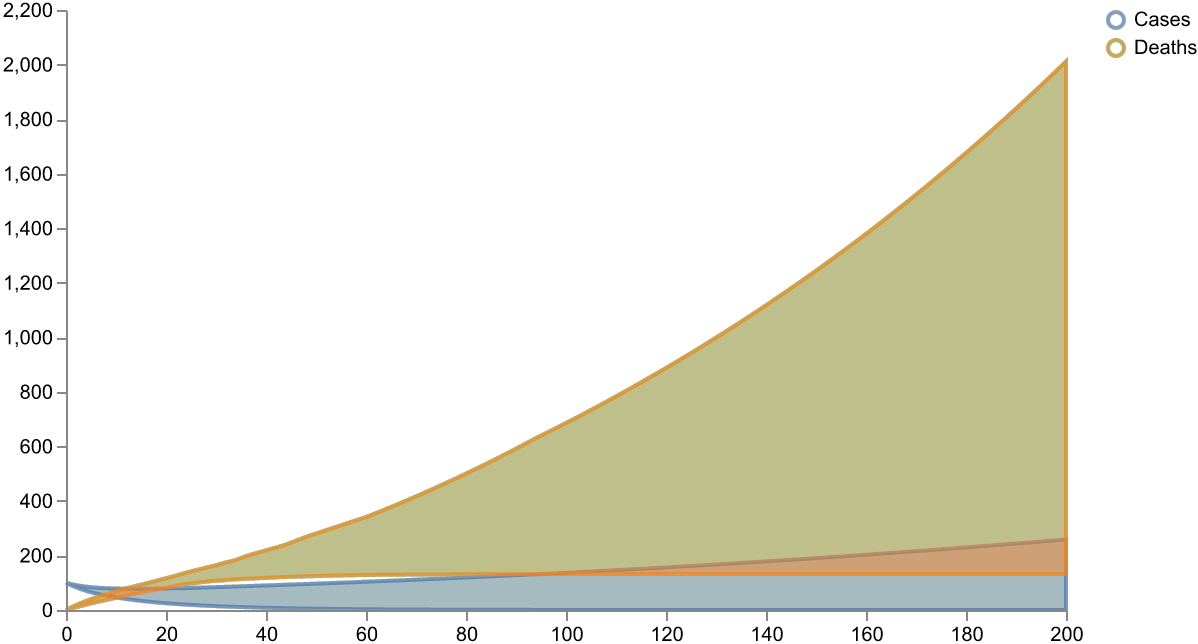

In [54]:
result1 = pyciemss.sample(model_seid, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

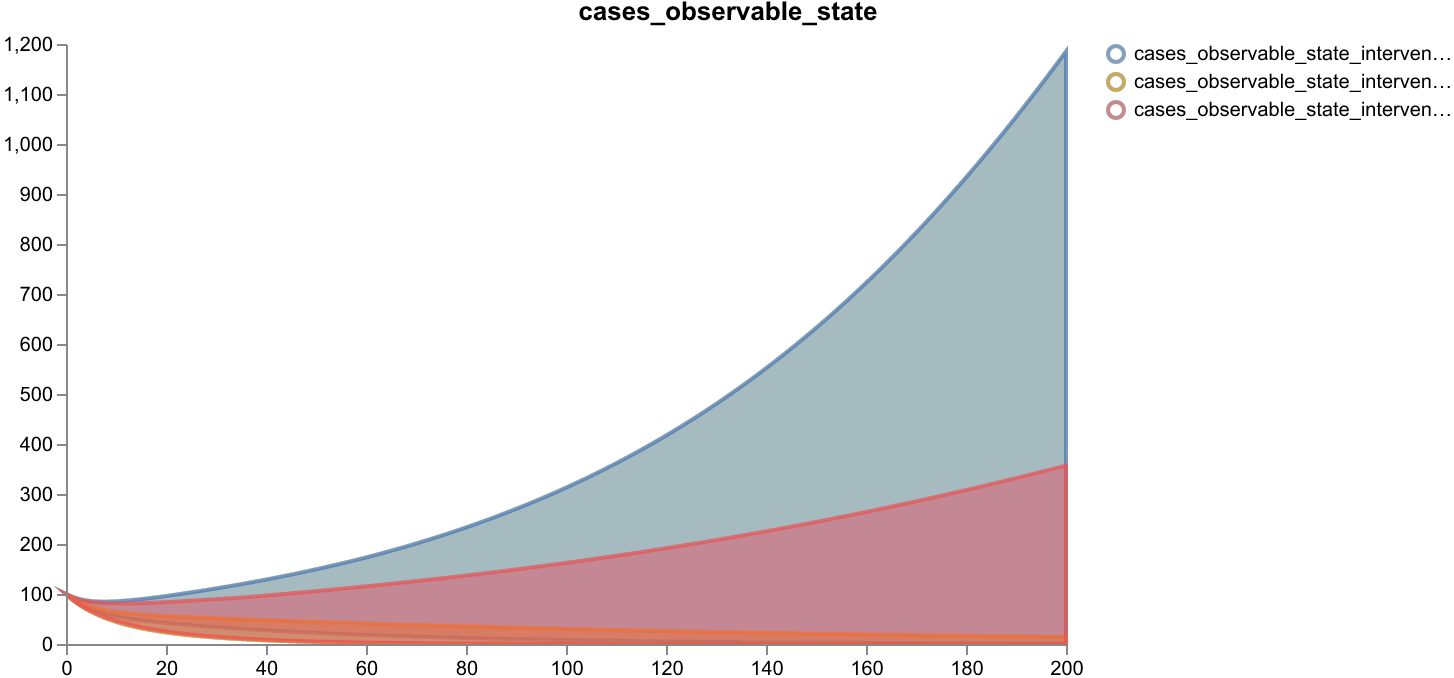

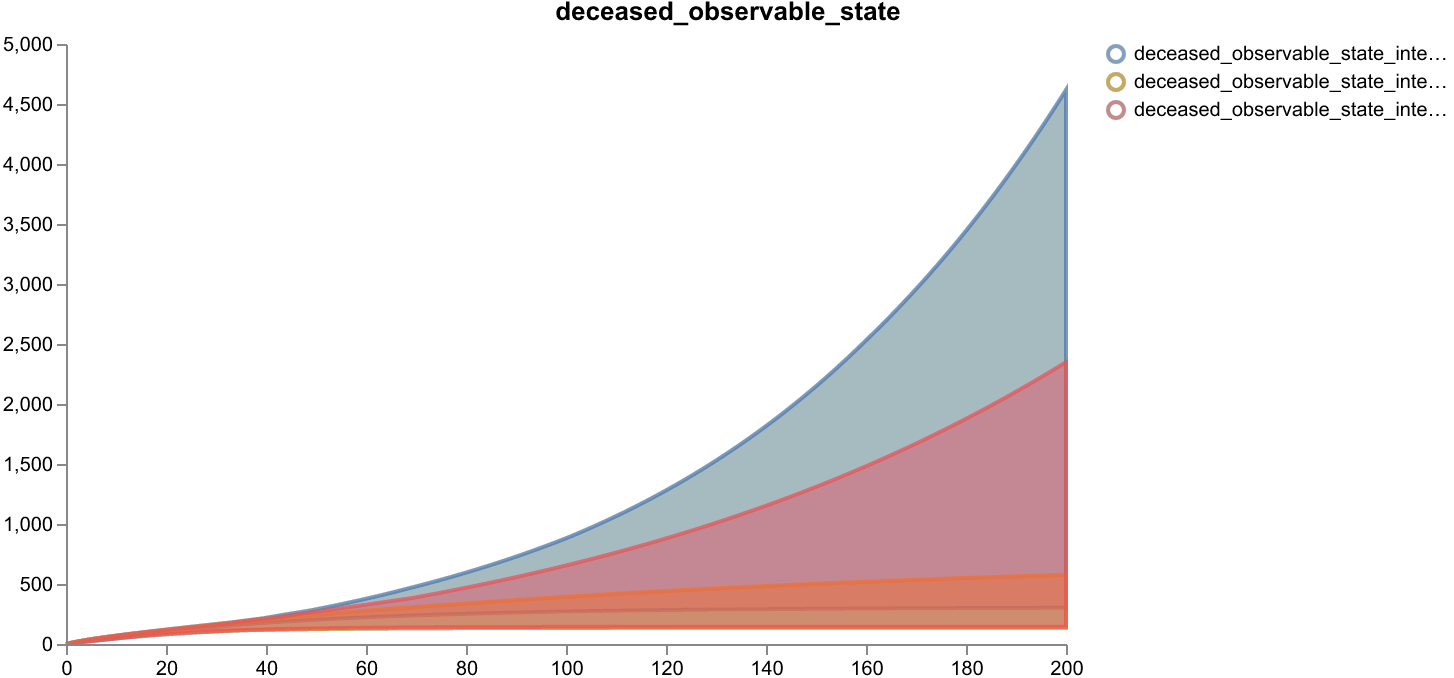

In [66]:
models = {"seir_model":seir_model, "mu_max": seir_model_mu_max, "beta_max": seir_model_beta_max}
nice_labels = {
    "cases_observable_state": "Cases",
    "deceased_observable_state": "Deaths"
}
results_dict_dist = {}

all_results = pd.DataFrame()
for key, model in models.items():
    invervention_sample_results = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                                start_time=start_time)
    # Save results to a DataFrame with intervention-named columns
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for label in nice_labels:
        if label in invervention_sample_results["data"].columns:
            all_results[f"{label}_intervention_{key}"] = invervention_sample_results["data"][label]

    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {nice_labels[label]: final_results[label].values for label in nice_labels}
    results_dict_dist[f"intervention_{key}"] = intervention_results



# Display separately for each observable state
for state in ["cases_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=nice_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))